# 3D Protein Pose Recovery

In [1]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib 
tf.__version__

'2.0.0'

In [2]:
!echo $CUDA_VISIBLE_DEVICES

2


In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17866085473772051711
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3859295133776625893
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17084042910153634013
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329617920
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 14351513877695603999
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


## (1) Generate Sythetic Data

In [4]:
DATA_DIR        = "../data"
RESULTS_DIR     = "/mnt/scratch/students"

In [5]:
PROTEIN         = "5j0n"

PROJECTIONS_NUM = 5000
INPUT_FILE      = f"{PROTEIN}.mrc"
ANGLE_COVERAGE  = [2.0, 1.0, 0.5]
ANGLE_SHIFT     = [0., 0., 0.]
OUTPUT_FILE     = f"{PROTEIN}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5"

In [6]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
generate_2D_projections(input_file_path=f"{DATA_DIR}/{INPUT_FILE}", 
                        ProjNber=PROJECTIONS_NUM,
                        AngCoverage=ANGLE_COVERAGE,
                        AngShift=ANGLE_SHIFT,
                        angles_gen_mode="uniform_angles",
                        output_file_name=f"{RESULTS_DIR}/{OUTPUT_FILE}")

* Loading the dataset *

Projections: (5000, 116, 116)
Angles: (5000, 3)



In [7]:
f"{RESULTS_DIR}/{OUTPUT_FILE}"

'/mnt/scratch/students/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift2.0,1.0,0.5.h5'

In [8]:
# read stored data for further processing
data = h5py.File(f"{RESULTS_DIR}/{OUTPUT_FILE}", 'r')
projections = data['Projections']
projections_original = data['Projections']
angles_true = np.array(data['Angles'])

print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images


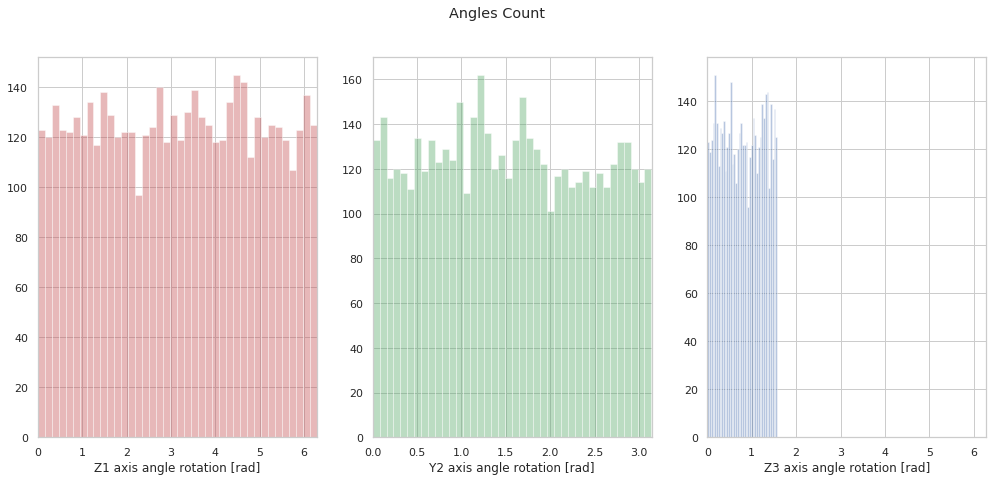

In [9]:
plot_angles_count(angles_true)

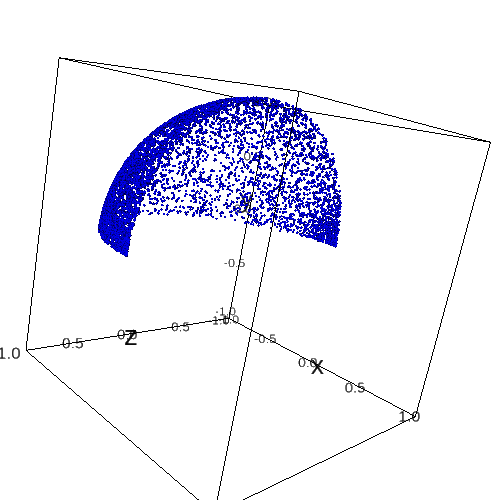

In [7]:
plot_detector_pixels(angles_true)

In [8]:
ipv.screenshot()

Output()

## (2) Preprocessing Data

In [9]:
NOISY_VAR = 10
TRANSLATION = 5

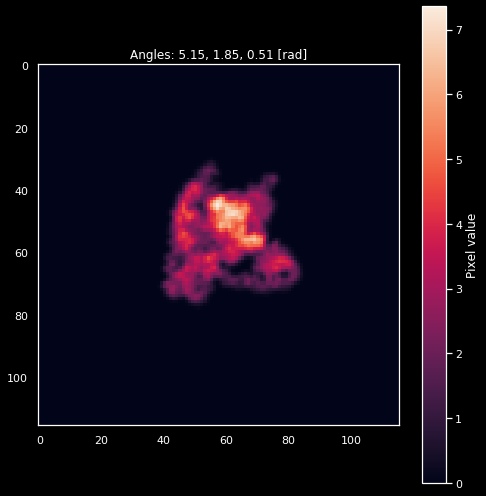

In [10]:
plot_projection(projections[0], angles=angles_true[0])

In [11]:
projections = preprocessing(projections, noise_var=NOISY_VAR, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels="gray")

--- Preprocessing projections ---
Image rescaled: from dimension 116 to 128 for MobileNet
Noise:
Variance=10
Translation:
left_limit=-5, peak_limit=0, right_limit=5
Global standardization
	Image shape: (128, 128)
	Data Type: float64
	Mean: 0.261 | Std: 3.323
	Min:  -19.635 | Max: 23.904
	Mean: -0.000 | Std: 1.000
	Min:  -5.987 | Max: 7.115


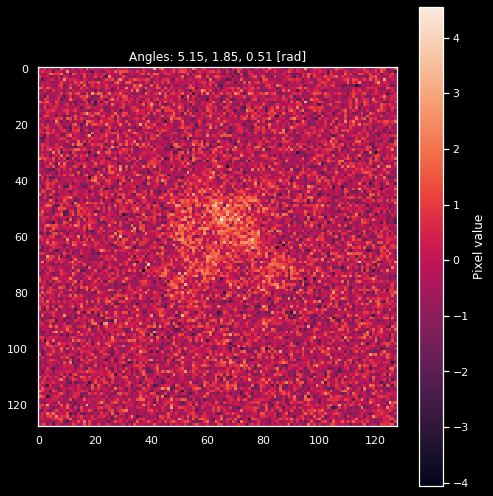

In [12]:
plot_projection(projections[0], angles=angles_true[0])

## (3) Distance Learning

In [13]:
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"
DE_DESCRIPTION = "full_pipeline_test"

In [14]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.33, val_size=0.25, train_percent=0.01, val_percent=0.01)

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6310144   |   63101
TEST :               0.33 =>  1650 imgs => max pairs:    2722500   |   all
VAL  : 0.67 x 0.25 = 0.17 =>   838 imgs => max pairs:     702244   |   7022
Indices stored in ../data/train_val_test_indices.npz


In [ ]:
model, history = train_distance_estimation(X=projections, y=angles_true, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=50,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

Data created in 4.319854497909546 sec
Data created in 0.4799039363861084 sec
Input images shape (128, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
_________________________________________________________________________________

In [15]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [16]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

<Figure size 432x288 with 0 Axes>

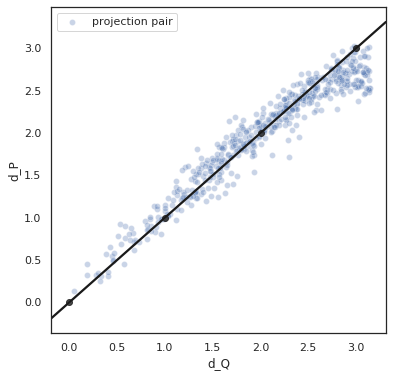

<Figure size 432x288 with 0 Axes>

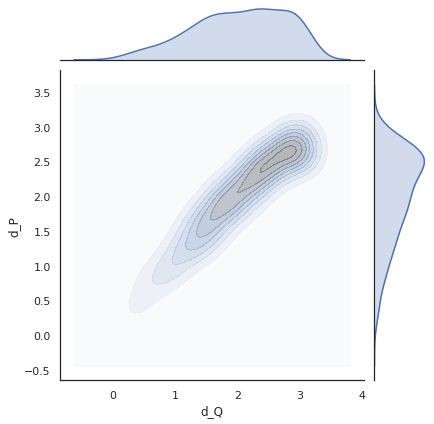

Variance = 0.201255941127686
Min. angle recovery loss possible = 0.040424844554348444


In [17]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [projections[i] for i in idx1]
p2 = [projections[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

## (4) Angle Recovery

In [18]:
from cryoem.angle_recovery import train_angle_recovery

In [19]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery"
AR_TRAINING_DESCRIPTION = "full_pipeline_test"

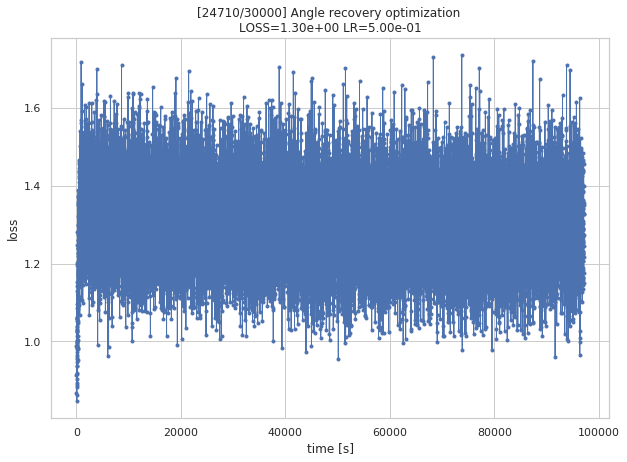

KeyboardInterrupt: 

In [22]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                 batch_size=256, 
                                                 in_data=projections, 
                                                 distance_fn=d_p, 
                                                 learning_rate=0.5, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=True)

In [28]:
from cryoem.conversions import quaternion2euler

In [29]:
angles_predicted = quaternion2euler(q_predicted)

## (5) Angle Alignment

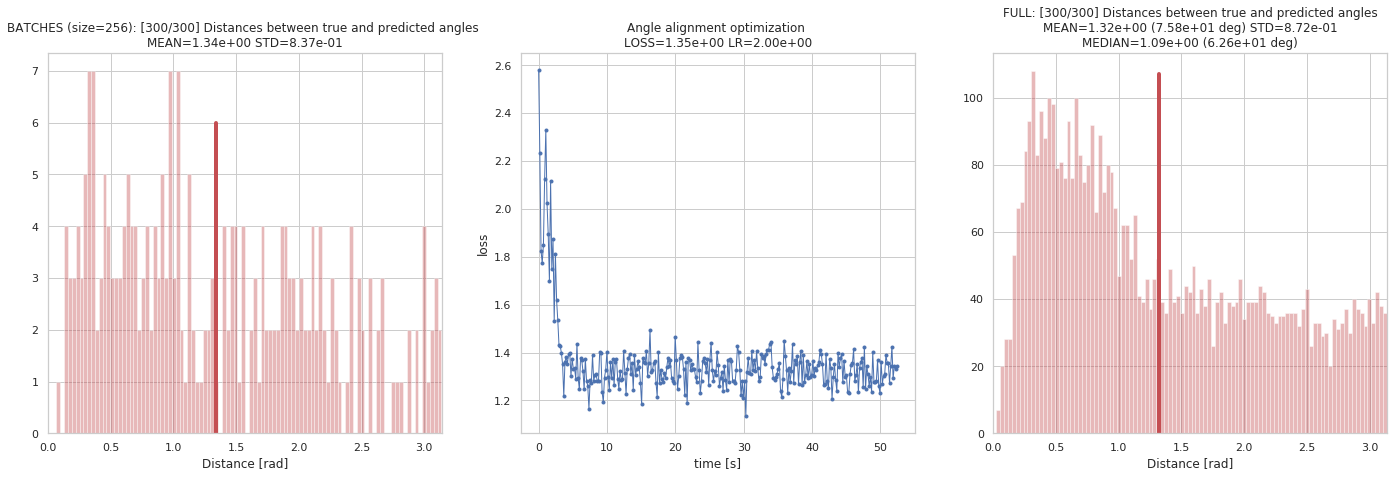

step 30/300 (6s): loss = 1.69e+00
step 60/300 (11s): loss = 1.31e+00
step 90/300 (16s): loss = 1.32e+00
step 120/300 (22s): loss = 1.33e+00
step 150/300 (27s): loss = 1.33e+00
step 180/300 (32s): loss = 1.31e+00
step 210/300 (38s): loss = 1.34e+00
step 240/300 (43s): loss = 1.34e+00
step 270/300 (48s): loss = 1.32e+00
step 300/300 (53s): loss = 1.32e+00



In [30]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=300, 
                                                                    batch_size=256, 
                                                                    optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true, 
                                                                    angles_predicted=angles_predicted)

In [31]:
m = m
trajectory_first = trajectory[0]
loss_first = losses[0]
trajectory_last = trajectory[-1]
loss_last = losses[-1]

m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 array([5.83613318, 3.69104361, 3.93308986, 5.73198663, 3.40978182,
        6.20644198]),
 2.3012394321123035,
 array([ 19.79133028,  16.11193187,  15.6497645 , -16.37826613,
         14.4912744 ,  -2.33648046]),
 0.8389643407424416)

In [32]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

## (6) Reconstruction

In [35]:
from cryoem.reconstruction import reconstruct

In [36]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test.mrc"

In [39]:
reconstruct(projections_original, angles_predicted, mrc_filename=f"{REC_LOGS_DIR}/{REC_DESCRIPTION}")

array([[[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 2, 2, 2],
        [3, 3, 3, ..., 2, 2, 2],
        [3, 3, 3, ..., 2, 2, 2]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 2, 2, 2],
        [3, 3, 3, ..., 2, 2, 2],
        [3, 3, 3, ..., 2, 2, 2]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 2, 2, 2],
        [3, 3, 3, ..., 2, 2, 2],
        [3, 3, 3, ..., 2, 2, 2]],

       ...,

       [[3, 3, 3, ..., 3, 2, 2],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       [[3, 3, 3, ..., 3, 3, 2],
        [2, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 